# Data split for the 4-fold CV

---

This notebook can be used to generate data splits for the screening data to allow for parallel computing of the screens.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
import os
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt

---
## 1. Read in data

To start we will read in the whole metadata set.

In [2]:
md_ko = pd.read_csv(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/preprocessing/full_pipeline/20241018_015541/padded_nuclei_metadata_fileExists.csv.gz",
    index_col=0,
)
md_ko.head()

,source,batch,plate,well,site,image_file,gene_symbol,bb_width,bb_height,minor_axis_length,major_axis_length,aspect_ratio,aspect_ratio_cluster,nuclei_count_image,slide_image_name,aspect_ratio_cluster_ratio,centroid_0,centroid_1
0,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,34,21,18.152311,36.641606,0.495402,0,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,29.588694,207.678363
1,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,24,32,20.726421,33.983415,0.609898,0,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,42.947177,1229.174863
2,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,32,39,28.960515,41.599552,0.696174,1,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,80.714286,1196.022222
3,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,22,35,22.335351,35.301121,0.632709,0,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,87.434572,1124.943457
4,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,29,52,25.967213,55.164771,0.470721,0,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,92.285843,189.496844


In [3]:
md_compound = pd.read_csv(
    "/data/xinyi/image2reg/data_new/experiments/jump_compound/images/preprocessing/full_pipeline/20241025_161036/padded_nuclei_metadata_fileExists.csv.gz",
    index_col=0,
)
md_compound.head()

,source,batch,plate,well,site,image_file,gene_symbol,bb_width,bb_height,minor_axis_length,major_axis_length,aspect_ratio,aspect_ratio_cluster,nuclei_count_image,slide_image_name,aspect_ratio_cluster_ratio,centroid_0,centroid_1
0,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,27,32,27.263139,33.298781,0.818743,0,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,22.942335,1232.897328
1,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,35,19,18.711072,36.371191,0.514448,1,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,29.754753,552.490494
2,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,28,30,23.319638,33.555792,0.694951,0,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,29.530945,840.661238
3,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,34,27,22.989829,36.280641,0.633667,0,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,37.877301,881.897239
4,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,29,34,26.717761,36.065574,0.740811,0,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,36.644180,994.552910


In [4]:
spec_results = pd.read_csv(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
# .union(
#     set(["CCNE1", "CDK2", "GSK3B", "MAPK8", "PRKCA", "RPS6KB1", "TCF4", "TGFB1"])
# )

In [5]:
spec_orf_targets

{'ALOX5',
 'ATF4',
 'AURKA',
 'AURKB',
 'AXL',
 'BAX',
 'BCL2L11',
 'BIRC5',
 'BMP4',
 'BRAF',
 'BUB1',
 'CASP8',
 'CCNA2',
 'CCNB1',
 'CCNB2',
 'CCND2',
 'CCNE1',
 'CCNF',
 'CD40',
 'CDC42',
 'CDC6',
 'CDCA3',
 'CDK1',
 'CDK14',
 'CDK2',
 'CDK6',
 'CEBPA',
 'CENPE',
 'CKS2',
 'CREB1',
 'CYBA',
 'DHRS2',
 'E2F1',
 'EEF1A2',
 'FEN1',
 'FGF1',
 'FGFR3',
 'FKBP4',
 'FN1',
 'FOS',
 'FOXO1',
 'GLI1',
 'GLI2',
 'GSK3B',
 'GTSE1',
 'HK2',
 'HRAS',
 'HSPA1B',
 'IGF2',
 'INHBA',
 'IRAK4',
 'IRF7',
 'JUN',
 'KIF15',
 'KIF23',
 'KIF2C',
 'KIF4A',
 'KLK6',
 'KPNA2',
 'KRT8',
 'LOXL4',
 'LRP1',
 'MAP3K2',
 'MAP3K5',
 'MAP3K9',
 'MAPK7',
 'MAPK8',
 'MCM3',
 'MCM4',
 'MCM5',
 'MCM7',
 'MDK',
 'MMP2',
 'MSH2',
 'MYBL2',
 'MYC',
 'MYH9',
 'NCF2',
 'NCOR2',
 'NEK2',
 'NOTCH3',
 'PAK2',
 'PARP2',
 'PCNA',
 'PIK3R2',
 'PLCB2',
 'PLCG1',
 'PLK1',
 'PRKACA',
 'PRKCA',
 'RARA',
 'RELB',
 'RHOA',
 'RPS6KB1',
 'RRM2',
 'SKP2',
 'SMO',
 'SREBF1',
 'TGFB1',
 'TGM2',
 'THRA',
 'TIMP1',
 'TINAGL1',
 'TNC',
 'TONSL

---

## 2. StratifiedGrouped K-Fold

We will now go over each individual gene and add a column to the dataframe that indicates to which fold of the respective gene screen the respective nuclei corresponds to. Thereby, we will ensure that all nuclei from the same slide-image are in the same fold to ensure that the model cannot cheat by focussing on imaging artifacts specific to individual slide images.

In [6]:
output_dir = "/data/xinyi/image2reg/data_new/experiments/jump/images/preprocessing/specific_targets_combined_excludeCompound/"
os.makedirs(output_dir, exist_ok=True)

In [8]:
label_col = "gene_symbol"
group_col = "slide_image_name"
random_state = 1234
# n_folds = 5
val_size=0.1
test_size=0.05

labels_all =np.copy(md_ko.loc[:, label_col])
labels_all[labels_all=='non-targeting']='NC'
labels_all[labels_all=='no-guide']='NC'
md_ko[label_col]=labels_all

In [10]:
_,gcounts=np.unique(labels_all[labels_all!='NC'],return_counts=True)
np.min(gcounts)

1749

(array([ 5.,  4.,  5., 10., 25., 53., 30.,  6.,  3.,  2.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1749.  ,  3436.04,  5123.08,  6810.12,  8497.16, 10184.2 ,
        11871.24, 13558.28, 15245.32, 16932.36, 18619.4 , 20306.44,
        21993.48, 23680.52, 25367.56, 27054.6 , 28741.64, 30428.68,
        32115.72, 33802.76, 35489.8 , 37176.84, 38863.88, 40550.92,
        42237.96, 43925.  , 45612.04, 47299.08, 48986.12, 50673.16,
        52360.2 , 54047.24, 55734.28, 57421.32, 59108.36, 60795.4 ,
        62482.44, 64169.48, 65856.52, 67543.56, 69230.6 , 70917.64,
        72604.68, 74291.72, 75978.76, 77665.8 , 79352.84, 81039.88,
        82726.92, 84413.96, 86101.  ]),
 <BarContainer object of 50 artists>)

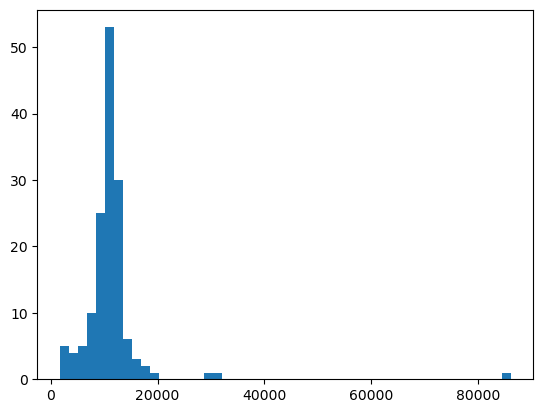

In [11]:
plt.hist(gcounts,bins=50)

In [12]:
np.unique(md_compound.gene_symbol)

array(['APPBP2', 'AQP1', 'AURKA', 'AURKB', 'BIRC5', 'CCNA2', 'CDK1',
       'CDK2', 'CDK6', 'DMSO', 'EEF1A2', 'FGF1', 'FGFR2', 'FGFR3',
       'GABRB3', 'GSK3B', 'LGALS1', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK8',
       'PARP2', 'PCNA', 'PDGFRB', 'PLAT', 'PRKACA', 'RARA', 'THRA', 'TK1',
       'TLR4', 'TNNC1'], dtype=object)

In [16]:
exclude_set = set(np.unique(md_compound.gene_symbol))
target_list = sorted(item for item in list(spec_orf_targets) + ["NC"] if item not in exclude_set)
print(target_list)

label_data = md_ko.loc[md_ko.loc[:, label_col].isin(target_list), :]
if "NC" in target_list:
    idc = np.array(list(range(len(label_data)))).reshape(-1, 1)
    labels = label_data.loc[:, label_col]
    sample_count_dict = dict(Counter(labels))
    # sample_count_dict["NC"] = np.max(list(sample_count_dict.values()))
    sample_count_dict = {label: min(sample_count_dict[label], 15245) for label in sample_count_dict}
    # sample_count_dict["NC"] = min(sample_count_dict["NC"],int(15245/2))
    # sample_count_dict["NC-K"] = min(sample_count_dict["NC-K"],int(15245/2))
    print(sample_count_dict)
    idc, _ = RandomUnderSampler(
        sampling_strategy=sample_count_dict, random_state=random_state
    ).fit_resample(idc, labels)
    label_data = label_data.iloc[idc.flatten(), :]

# Split in folds
labels = label_data.loc[:, label_col]
# labels[labels=='NC-K']='NC'
label_data[label_col]=labels

features = np.array(list(range(len(label_data)))).reshape(-1, 1)
labels = np.array(label_data.loc[:, label_col])
groups = np.array(label_data.loc[:, group_col])

trainval_index, test_index = next(
    StratifiedGroupKFold(n_splits=int(1.0 / test_size)).split(
        label_data, labels, groups=groups
    )
)
trainval_data = label_data.iloc[trainval_index]
test_data = label_data.iloc[test_index]
test_data.to_csv(os.path.join(output_dir, "nuclei_md_test.csv"))

trainval_labels = labels[trainval_index]
trainval_groups = groups[trainval_index]

train_index, val_index = next(
    StratifiedGroupKFold(n_splits=int((1.0-val_size-test_size) / val_size)).split(
        trainval_data, trainval_labels, groups=trainval_groups
    )
)
trainval_data.iloc[train_index].to_csv(os.path.join(output_dir, "nuclei_md_train.csv"))
trainval_data.iloc[val_index].to_csv(os.path.join(output_dir, "nuclei_md_val.csv"))

['ALOX5', 'ATF4', 'AXL', 'BAX', 'BCL2L11', 'BMP4', 'BRAF', 'BUB1', 'CASP8', 'CCNB1', 'CCNB2', 'CCND2', 'CCNE1', 'CCNF', 'CD40', 'CDC42', 'CDC6', 'CDCA3', 'CDK14', 'CEBPA', 'CENPE', 'CKS2', 'CREB1', 'CYBA', 'DHRS2', 'E2F1', 'FEN1', 'FKBP4', 'FN1', 'FOS', 'FOXO1', 'GLI1', 'GLI2', 'GTSE1', 'HK2', 'HRAS', 'HSPA1B', 'IGF2', 'INHBA', 'IRAK4', 'IRF7', 'JUN', 'KIF15', 'KIF23', 'KIF2C', 'KIF4A', 'KLK6', 'KPNA2', 'KRT8', 'LOXL4', 'LRP1', 'MAPK7', 'MCM3', 'MCM4', 'MCM5', 'MCM7', 'MDK', 'MMP2', 'MSH2', 'MYBL2', 'MYC', 'MYH9', 'NC', 'NCF2', 'NCOR2', 'NEK2', 'NOTCH3', 'PAK2', 'PIK3R2', 'PLCB2', 'PLCG1', 'PLK1', 'PRKCA', 'RELB', 'RHOA', 'RPS6KB1', 'RRM2', 'SKP2', 'SMO', 'SREBF1', 'TGFB1', 'TGM2', 'TIMP1', 'TINAGL1', 'TNC', 'TONSL', 'TP73', 'TPM1', 'TRAF2', 'TRIB3', 'TSC2', 'TTK', 'TUBB6', 'UBE2C', 'UBE2S', 'WEE1', 'WWTR1', 'YWHAQ']
{'ALOX5': 11641, 'ATF4': 8318, 'AXL': 9626, 'BAX': 11416, 'BCL2L11': 8782, 'BMP4': 11742, 'BRAF': 11327, 'BUB1': 9437, 'CASP8': 15245, 'CCNB1': 8407, 'CCNB2': 9897, 'CCND2

In [17]:
len(set(test_data.gene_symbol))

98

<AxesSubplot: xlabel='gene_symbol'>

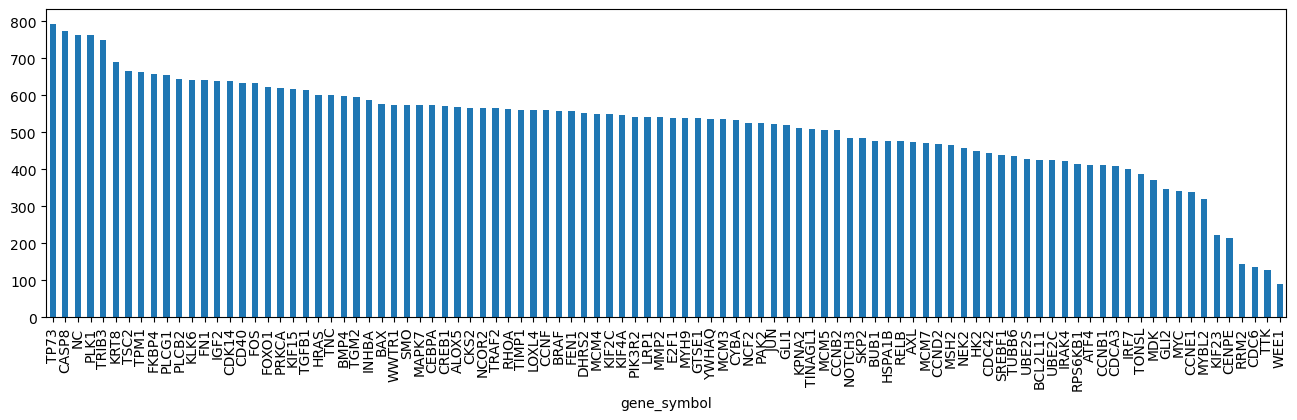

In [18]:
test_data.gene_symbol.value_counts().plot(kind="bar", figsize=(16, 4))

In [19]:
np.sum(test_data.gene_symbol=='NC')

762

In [20]:
#save all compounds
label_data_compound = md_compound.loc[md_compound.loc[:, label_col].isin(target_list), :]
# label_data_compound.to_csv(os.path.join(output_dir, "nuclei_md_compound.csv"))

In [21]:
np.unique(md_compound.loc[:, label_col])

array(['APPBP2', 'AQP1', 'AURKA', 'AURKB', 'BIRC5', 'CCNA2', 'CDK1',
       'CDK2', 'CDK6', 'DMSO', 'EEF1A2', 'FGF1', 'FGFR2', 'FGFR3',
       'GABRB3', 'GSK3B', 'LGALS1', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK8',
       'PARP2', 'PCNA', 'PDGFRB', 'PLAT', 'PRKACA', 'RARA', 'THRA', 'TK1',
       'TLR4', 'TNNC1'], dtype=object)

In [22]:
np.unique(label_data_compound.gene_symbol)

array([], dtype=object)

In [37]:
label_data_compound_others = md_compound.loc[~md_compound.loc[:, label_col].isin(target_list), :]
label_data_compound_others.to_csv(os.path.join(output_dir, "nuclei_md_compound_others.csv"))

In [38]:
np.unique(label_data_compound_others.gene_symbol)

array(['APPBP2', 'AQP1', 'FGFR2', 'GABRB3', 'LGALS1', 'PDGFRB', 'PLAT',
       'TK1', 'TLR4', 'TNNC1'], dtype=object)